# Deep learning course for astro PhD students

##### Alexandre Boucaud (Paris Saclay CDS)
##### Marc Huertas-Company (LERMA)

1. [Introduction](#Introduction)
2. [Data](#Data)
3. [Workflow](#Workflow)
4. [Evaluation](#Evaluation)
5. [Local testing/exploration](#Local-testing)
6. [Submission](#Submitting-to-ramp.studio)

## Introduction

In astronomical images, the projection effects may cause two or more galaxies to overlap. When they are barely indistinguishable from one another, they are referred to as _blended_ and this can bias astrophysical estimators such as the morphology of galaxies or the shear (weak gravitational lensing distortion).  
As the sensitivity of imaging devices grows, a high fraction of galaxies appear _blended_ in the images, which is a known and important issue for current and upcoming galaxy surveys.  

In order not to discard such a wealth of information, it is key to develop methods to enable astronomers to alleviate such effect.
We can foresee some features that would help, in which machine learning could provide a solution:
- classify an image as containing isolated/blended objects  
  ___binary classification___
- count the number of blended sources in a blended image  
  ___regression / object detection___
- find the contours of each object  
  ___object detection/segmentation___
- ...

In this exercice, we will approach the third item, the detection of contours, but in a constrained way : the images will only contain **two galaxies** and the goal will be to find the **contours of the overlapping region** between both galaxies.

## Data



In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
!ls data

test_blends_mini.npy        train_blends_mini.npy
test_target_img_mini.npy    train_target_img_mini.npy
test_target_masks_mini.npy  train_target_masks_mini.npy


In [6]:
blends = np.load('data/train_blends_mini.npy')
galaxies = np.load('data/train_target_img_mini.npy')
masks = np.load('data/train_target_masks_mini.npy')

In [7]:
def plot_data_basic(idx):
    titles = [
        'blended galaxies',
        'central galaxy',
        'segmap of central galaxy'
    ]

    fig_size = (12, 5)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=fig_size)
    axes[0].imshow(blends[idx])
    axes[1].imshow(galaxies[idx])
    axes[2].imshow(masks[idx], cmap='Greys_r')
    for title, ax in zip(titles, axes):
        ax.set_title(title)
        ax.set_axis_off()

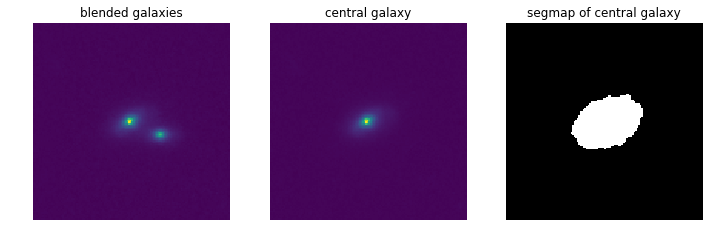

In [8]:
index = np.random.randint(200)
plot_data_basic(index)

## Workflow

Inside `object_detector.py`, the workflow expects a Python class called `ObjectDetector` 
with two required methods implemented : `fit()` and `predict()`

```python
class ObjectDetector:
    def __init__(self): pass
    def fit(self): pass
    def predict(self): pass
``` 

Here is a look at how the ObjectDetector was implemented to run your model.
It will give you an idea of how to organize your code. 

In [ ]:
import numpy as np

from sklearn.utils import Bunch

from keras.models import Sequential
from keras.layers import Conv2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers.noise import GaussianNoise


class ObjectDetector(object):
    """Object detector.

    Parameters
    ----------
    batch_size : int, optional
        The batch size used during training. Set by default to 32 samples.

    epoch : int, optional
        The number of epoch for which the model will be trained. Set by default
        to 50 epochs.

    model_check_point : bool, optional
        Whether to create a callback for intermediate models.

    Attributes
    ----------
    model_ : object
        The DNN model.

    params_model_ : Bunch dictionary
        All hyper-parameters to build the DNN model.

    """

    def __init__(self, model, batch_size=32, epoch=10, model_check_point=True):
        self.model_ = self._build_model(model)
        self.params_model_ = self._init_params_model()
        self.batch_size = batch_size
        self.epoch = epoch
        self.model_check_point = model_check_point

    def fit(self, X, y, pretrained=False):

        if pretrained:
            # for showcase load weights (this is not possible
            # for an actual submission)
            self.model_.load_weights(
                'submissions/keras_fcnn/fcnn_weights_best.h5')
            return

        # build the box encoder to later encode y to make usable in the model
        train_dataset = BatchGeneratorBuilder(X, y)
        train_generator, val_generator, n_train_samples, n_val_samples = \
            train_dataset.get_train_valid_generators(
                batch_size=self.batch_size)

        # create the callbacks to get during fitting
        callbacks = self._build_callbacks()

        # fit the model
        self.model_.fit_generator(
            generator=train_generator,
            steps_per_epoch=ceil(n_train_samples / self.batch_size),
            epochs=self.epoch,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=ceil(n_val_samples / self.batch_size))

    def predict(self, X):
        return self.model_.predict(np.expand_dims(X, -1))

    ###########################################################################
    # Setup model

    @staticmethod
    def _init_params_model():
        params_model = Bunch()

        # optimizer parameters
        params_model.lr = 1e-4
        params_model.beta_1 = 0.9
        params_model.beta_2 = 0.999
        params_model.epsilon = 1e-08
        params_model.decay = 5e-05

        # loss parameters
        params_model.keras_loss = 'binary_crossentropy'

        # callbacks parameters
        params_model.early_stopping = True
        params_model.es_patience = 12
        params_model.es_min_delta = 0.001

        params_model.reduce_learning_rate = True
        params_model.lr_patience = 5
        params_model.lr_factor = 0.5
        params_model.lr_min_delta = 0.001
        params_model.lr_cooldown = 2

        return params_model

    def _build_model(self, model):

        # load the parameter for the SSD model
        params_model = self._init_params_model()

        optimizer = Adam(lr=params_model.lr)

        model.compile(optimizer=optimizer, loss=params_model.keras_loss)

        return model, params_model

    def _build_callbacks(self):
        callbacks = []

        if self.model_check_point:
            callbacks.append(
                ModelCheckpoint('./fcnn_weights_best.h5',
                                monitor='val_loss',
                                save_best_only=True,
                                save_weights_only=True,
                                period=1,
                                verbose=1))
        # add early stopping
        if self.params_model_.early_stopping:
            callbacks.append(
                EarlyStopping(monitor='val_loss',
                              min_delta=self.params_model_.es_min_delta,
                              patience=self.params_model_.es_patience,
                              verbose=1))

        # reduce learning-rate when reaching plateau
        if self.params_model_.reduce_learning_rate:
            callbacks.append(
                ReduceLROnPlateau(monitor='val_loss',
                                  factor=self.params_model_.lr_factor,
                                  patience=self.params_model_.lr_patience,
                                  cooldown=self.params_model_.lr_cooldown,
                                  # min_delta=self.params_model_.lr_min_delta,
                                  verbose=1))

        return callbacks


The model given as example in this repository is a very basic FCNN (fully convolutional neural network) with several layers.

In [ ]:
def model():
    input_shape = (128, 128, 1)
    output_channels = 1
    depth = 16
    n_layers = 6
    conv_size0 = (3, 3)
    conv_size = (3, 3)
    last_conv_size = (3, 3)
    activation = "relu"
    last_activation = "sigmoid"
    dropout_rate = 0
    sigma_noise = 0.01
    initialization = "he_normal"

    model = Sequential()
    model.add(
        Conv2D(
            depth,
            conv_size0,
            input_shape=input_shape,
            activation=activation,
            padding="same",
            name="conv0",
            kernel_initializer=initialization,
        )
    )
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    for layer_n in range(1, n_layers):
        model.add(
            Conv2D(
                depth,
                conv_size,
                activation=activation,
                padding="same",
                name="conv{}".format(layer_n),
                kernel_initializer=initialization,
            )
        )
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    if sigma_noise > 0:
        model.add(GaussianNoise(sigma_noise))

    model.add(
        Conv2D(
            output_channels,
            last_conv_size,
            activation=last_activation,
            padding="same",
            name="last",
            kernel_initializer=initialization,
        )
    )

    return model

## Detection evaluation

For image detection a classical metric is the ***Intersection over Union (IoU)*** also referred to as ***Jaccard index*** and defined as

$$ IoU(A, B) =  \dfrac{|A \cap B|}{|A \cup B|} $$

This metric is very sensitive to small shifts or area difference between truth and prediction.

Typically, a value of IoU superior to 0.5 is used to define a good detection.

An implementation of the IoU for a series of flatten segmentation images $\in [0, 1]$ is 

In [ ]:
def iou_bitmap(y_true, y_pred, verbose=False):
    """
    Compute the IoU between two arrays

    If the arrays are probabilities (floats) instead of predictions (integers
    or booleans) they are automatically rounded to the nearest integer and
    converted to bool before the IoU is computed.

    Parameters
    ----------
    y_true : ndarray
        array of true labels
    y_pred : ndarray
        array of predicted labels
    verbose : bool (optional)
        print the intersection and union separately

    Returns
    -------
    float :
        the intersection over union (IoU) value scaled between 0.0 and 1.0

    """
    EPS = np.finfo(float).eps

    # Make sure each pixel was predicted e.g. turn probability into prediction
    if y_true.dtype in [np.float32, np.float64]:
        y_true = y_true.round().astype(bool)

    if y_pred.dtype in [np.float32, np.float64]:
        y_pred = y_pred.round().astype(bool)

    # Reshape to 1d
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # Compute intersection and union
    intersection = np.sum(y_true * y_pred)
    sum_ = np.sum(y_true + y_pred)
    jac = (intersection + EPS) / (sum_ - intersection + EPS)

    return jac


This is the metric used to score the segmentation.